# Can you tell what language a github repo is written in by analysing the language in the readme?

**Imports**

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import acquire
import prep

## Acquisition

In [2]:
df = acquire.get_github_data()
df.head()

,repo,language,readme_contents
0,freeCodeCamp/freeCodeCamp,JavaScript,![freeCodeCamp.org Social Banner](https://s3.a...
1,vuejs/vue,JavaScript,"<p align=""center""><a href=""https://vuejs.org"" ..."
2,facebook/react,JavaScript,# [React](https://reactjs.org/) &middot; [![Gi...
3,twbs/bootstrap,JavaScript,"<p align=""center"">\n <a href=""https://getboot..."
4,airbnb/javascript,JavaScript,# Airbnb JavaScript Style Guide() {\n\n*A most...


## Preparation

In [3]:
df = pd.read_csv('test.csv')
df = df.drop(68)

## Exploration

In [4]:
df['word_lists'] = df.clean_contents.str.split()
py_words = pd.Series(df[df.language == 'Python'].word_lists.sum())
js_words = pd.Series(df[df.language == 'JavaScript'].word_lists.sum())
java_words = pd.Series(df[df.language == 'Java'].word_lists.sum())
php_words = pd.Series(df[df.language == 'PHP'].word_lists.sum())
all_words = pd.Series(df.word_lists.sum())

In [5]:
py_freq = py_words.value_counts()
js_freq = js_words.value_counts()
java_freq = java_words.value_counts()
php_freq = php_words.value_counts()
all_freq = all_words.value_counts()

##### Most Common Words:

In [6]:
top_10 = {'all': all_freq.head(10).index, 
          'python': py_words.value_counts().index[:10], 
          'javascript': js_words.value_counts().index[:10],
          'java': java_words.value_counts().index[:10],
          'php': php_words.value_counts().index[:10]}
print('Top Ten per Category')
pd.DataFrame(top_10, index = range(1,11))

Top Ten per Category


,all,python,javascript,java,php
1,use,python,react,java,php
2,file,c,use,license,use
3,python,file,javascript,use,function
4,c,yes,const,support,class
5,php,use,file,spring,new
6,using,unknown,native,project,file
7,function,code,de,public,method
8,code,library,php,class,using
9,new,shell,using,new,default
10,support,data,function,android,value


In [7]:
word_counts = (pd.concat([all_freq,py_freq, java_freq, js_freq, php_freq], axis=1, sort=True)
                .set_axis(['all','python', 'java', 'javascript', 'php'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))
                
word_counts

,all,python,java,javascript,php
aa,3,1,0,2,0
aaa,1,0,0,1,0
aaaa,1,1,0,0,0
aaaaaaaaaaaaaaaaaaaa,2,2,0,0,0
aaaaaaaaaaaaaaaaaaaaa,1,1,0,0,0
...,...,...,...,...,...
zxp,2,0,0,2,0
zxvf,1,1,0,0,0
zycycleviewswift,2,2,0,0,0
zypper,1,0,0,1,0


In [8]:
print('most_common_words')
word_counts.sort_values(by='all', ascending=False).head(10)

most_common_words


,all,python,java,javascript,php
use,2242,723,254,820,445
file,1976,803,142,744,287
python,1847,1547,13,280,7
c,1724,1456,13,237,18
php,1623,38,5,646,934
using,1480,496,120,632,232
function,1326,253,17,619,437
code,1264,570,125,372,197
new,1184,243,178,459,304
support,1184,414,200,416,154


In [9]:
py_cloud = WordCloud(background_color='black', height=600, width=800).generate(' '.join(py_words[0:20]))
java_cloud=WordCloud(background_color='white', height=600, width=800).generate(' '.join(java_words[0:20]))
js_cloud=WordCloud(background_color='white', height=600, width=800).generate(' '.join(js_words[0:20]))
php_cloud=WordCloud(background_color='black', height=600, width=800).generate(' '.join(php_words[0:20]))

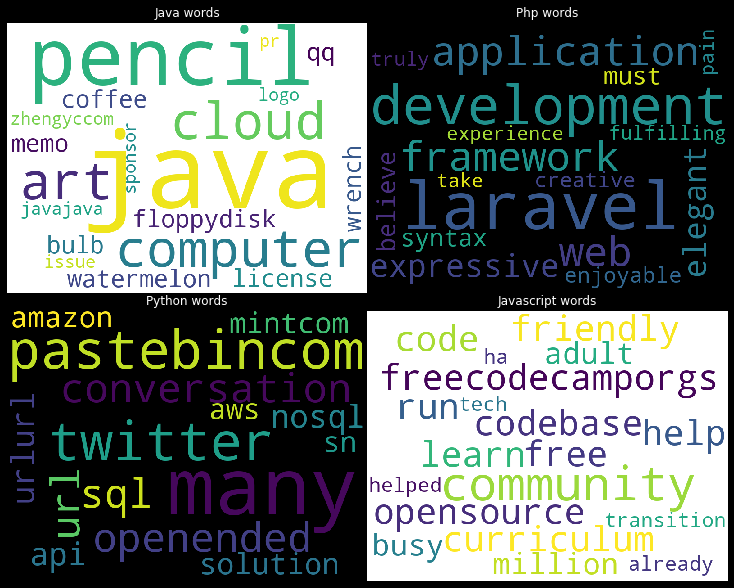

In [26]:
plt.style.use('dark_background')
plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, .5]), plt.axes([0, .5, .5, .5]), plt.axes([.5, 0, .5, .5]), plt.axes([.5, .5, .5, .5])]

axs[0].imshow(py_cloud)
axs[1].imshow(java_cloud)
axs[2].imshow(js_cloud)
axs[3].imshow(php_cloud)



axs[0].set_title('Python words')
axs[1].set_title('Java words')
axs[2].set_title('Javascript words')
axs[3].set_title('Php words')


for ax in axs: ax.axis('off')

**Average Lengths**

In [27]:
df['data_lengths'] = df.clean_contents.apply(len)

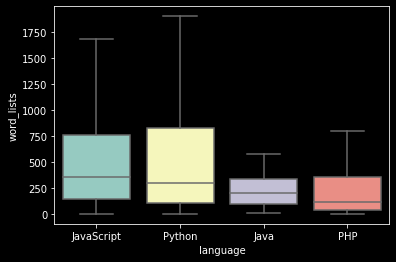

In [28]:
sns.boxplot(data=df, y = df.word_lists.apply(len), x = 'language', showfliers = False)

**Distributions**

In [29]:
word_counts = (pd.concat([all_freq, js_freq, py_freq, java_freq, php_freq], axis=1, sort=True)
                .set_axis(['all', 'js', 'python', 'java', 'php'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))


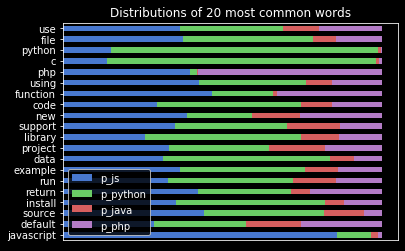

In [35]:
plt.style.use('seaborn-muted')
(word_counts
 .assign(p_js=word_counts.js / word_counts['all'],
         p_python=word_counts.python / word_counts['all'],
         p_java=word_counts.java / word_counts['all'],
         p_php=word_counts.php / word_counts['all']
         )
 .sort_values(by='all')
 [['p_js', 'p_python', 'p_java', 'p_php']]
 .tail(20)
 .plot.barh(stacked=True))
plt.legend(loc = 'lower left',frameon = True)
plt.xticks([])
plt.title('Distributions of 20 most common words')
plt.savefig('word_distributions',transparent = True)

## Modeling

In [15]:
# get tfs
tfidf = TfidfVectorizer()
tfidfs = tfidf.fit_transform(df['clean_contents'])
pd.DataFrame(tfidfs.todense(), columns = tfidf.get_feature_names()).head()


,aa,aaa,aaaa,aaaaaaaaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaa,aaaabaaaa,aaai,aac,aacfaaceasyaacencoderwindowslinuxarm,aadedddcefaccbeffb,...,zxf,zxing,zxingappspotcom,zxingbased,zxingorg,zxp,zxvf,zycycleviewswift,zypper,zyszysgmailcom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

X = pd.DataFrame(tfidfs.todense(), columns = tfidf.get_feature_names())
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify = y, random_state = 123)

train = pd.DataFrame(dict(actual = y_train))
test = pd.DataFrame(dict(actual = y_test))

tree = DecisionTreeClassifier(max_depth=9).fit(X_train,y_train)

train['predicted'] = tree.predict(X_train)
test['predicted']= tree.predict(X_test)

In [17]:
print('our train accuracy is: ',accuracy_score(train.actual, train.predicted))
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print(classification_report(train.actual, train.predicted))

our train accuracy is:  0.9357326478149101
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              precision    recall  f1-score   support

        Java       1.00      0.91      0.95        98
  JavaScript       1.00      0.91      0.95        97
         PHP       1.00      0.93      0.96        97
      Python       0.80      1.00      0.89        97

    accuracy                           0.94       389
   macro avg       0.95      0.94      0.94       389
weighted avg       0.95      0.94      0.94       389



In [18]:
print('our test accuracy is: ',accuracy_score(test.actual, test.predicted))
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print(classification_report(test.actual, test.predicted))

our test accuracy is:  0.8692307692307693
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              precision    recall  f1-score   support

        Java       0.88      0.88      0.88        32
  JavaScript       1.00      0.97      0.98        32
         PHP       0.93      0.76      0.83        33
      Python       0.72      0.88      0.79        33

    accuracy                           0.87       130
   macro avg       0.88      0.87      0.87       130
weighted avg       0.88      0.87      0.87       130



In [19]:
pd.crosstab(train.actual, train.predicted)

predicted,Java,JavaScript,PHP,Python
actual,,,,
Java,89,0,0,9
JavaScript,0,88,0,9
PHP,0,0,90,7
Python,0,0,0,97


In [20]:
lreg = LogisticRegression(random_state=123).fit(X_train,y_train)

train['predicted'] = lreg.predict(X_train)
test['predicted']= lreg.predict(X_test)

In [21]:
print('our train accuracy is: ',accuracy_score(train.actual, train.predicted))
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print(classification_report(train.actual, train.predicted))

our train accuracy is:  0.9974293059125964
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              precision    recall  f1-score   support

        Java       0.99      1.00      0.99        98
  JavaScript       1.00      1.00      1.00        97
         PHP       1.00      1.00      1.00        97
      Python       1.00      0.99      0.99        97

    accuracy                           1.00       389
   macro avg       1.00      1.00      1.00       389
weighted avg       1.00      1.00      1.00       389



In [22]:
print('our test accuracy is: ',accuracy_score(test.actual, test.predicted))
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print(classification_report(test.actual, test.predicted))

our test accuracy is:  0.9153846153846154
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
              precision    recall  f1-score   support

        Java       0.94      0.91      0.92        32
  JavaScript       0.89      1.00      0.94        32
         PHP       0.96      0.82      0.89        33
      Python       0.89      0.94      0.91        33

    accuracy                           0.92       130
   macro avg       0.92      0.92      0.91       130
weighted avg       0.92      0.92      0.91       130



In [23]:
pd.crosstab(test.actual, test.predicted)

predicted,Java,JavaScript,PHP,Python
actual,,,,
Java,29,0,0,3
JavaScript,0,32,0,0
PHP,1,4,27,1
Python,1,0,1,31
